In [8]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import urllib.parse

In [2]:
file_path = "dataset/phishing_url_website.csv" 
df = pd.read_csv(file_path)

In [3]:
df_features = df.copy()

In [4]:
df_features['label'] = df_features['label'].apply(lambda x: 1 if x == 0 else 0)

In [5]:
df_features.fillna(0, inplace=True)

In [6]:
scaler = StandardScaler()

In [10]:
feature_weights = {
    'HasIPAddress': 2,
    'URLLength': 1,
    'SuspiciousKeyword': 3,
    'DigitCount': 1,
    'HyphenCount': 1,
    'SubdomainCount': 2,
    'PhishingTLD': 3,
    'DigitToLengthRatio': 1,
    'SpecialCharCount': 2,
    'SlashCount': 1,
    'HasAtSymbol': 3,
    'HasHTTPSToken': 2,
    'HasURLEncoding': 2,
    'MultipleSubdomains': 3,
    'HasHexCharacters': 2,
    'DomainImpersonation': 4,
    'ConsecutiveRepeats': 3,
    'RandomStringDomain': 4,
    'DotCount': 1,
    'PathLength': 2
}

# Presence of an IP Address in URL
def has_ip_address(url):
    return feature_weights['HasIPAddress'] if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0

df_features['HasIPAddress'] = df_features['URL'].apply(has_ip_address)

# URL Length
df_features['URLLength'] = df_features['URL'].apply(lambda x: len(x) * feature_weights['URLLength'])

# Presence of suspicious keywords
suspicious_keywords = ['login', 'secure', 'bank', 'update', 'verify', 'account', 'password']
df_features['SuspiciousKeyword'] = df_features['URL'].apply(lambda x: feature_weights['SuspiciousKeyword'] if any(word in x.lower() for word in suspicious_keywords) else 0)

# Count of digits in URL
df_features['DigitCount'] = df_features['URL'].apply(lambda x: sum(c.isdigit() for c in x) * feature_weights['DigitCount'])

# Count of hyphens ('-') in URL
df_features['HyphenCount'] = df_features['URL'].apply(lambda x: x.count('-') * feature_weights['HyphenCount'])

# Count of subdomains
df_features['SubdomainCount'] = df_features['Domain'].apply(lambda x: urlparse(f"https://{x}").netloc.count('.') * feature_weights['SubdomainCount'])

# Check if the TLD is commonly associated with phishing
phishing_tlds = ['tk', 'ml', 'cf', 'ga', 'gq']
df_features['PhishingTLD'] = df_features['TLD'].apply(lambda x: feature_weights['PhishingTLD'] if x.lower() in phishing_tlds else 0)

# Ratio of Digits to Total Length in URL
df_features['DigitToLengthRatio'] = df_features.apply(
    lambda row: (row['DigitCount'] / row['URLLength'] if row['URLLength'] > 0 else 0) * feature_weights['DigitToLengthRatio'], axis=1
)

# Number of special characters in URL
df_features['SpecialCharCount'] = df_features['URL'].apply(lambda x: sum(not c.isalnum() for c in x) * feature_weights['SpecialCharCount'])

# Count of Slashes ('/') in the URL
df_features['SlashCount'] = df_features['URL'].apply(lambda x: x.count('/') * feature_weights['SlashCount'])

# Presence of '@' symbol in the URL
df_features['HasAtSymbol'] = df_features['URL'].apply(lambda x: feature_weights['HasAtSymbol'] if '@' in x else 0)

# Presence of 'https' token in the URL
df_features['HasHTTPSToken'] = df_features['URL'].apply(lambda x: feature_weights['HasHTTPSToken'] if 'https' in x.lower() and not x.startswith('https') else 0)

# Additional Features

# Presence of URL Encoding
def has_url_encoding(url):
    decoded_url = urllib.parse.unquote(url)
    return feature_weights['HasURLEncoding'] if url != decoded_url else 0

df_features['HasURLEncoding'] = df_features['URL'].apply(has_url_encoding)

# Presence of Multiple Subdomains
def multiple_subdomains(url):
    domain = urlparse(url).netloc
    return feature_weights['MultipleSubdomains'] if domain.count('.') > 2 else 0

df_features['MultipleSubdomains'] = df_features['URL'].apply(multiple_subdomains)

# Presence of Hexadecimal Characters in Domain
def has_hex_chars(url):
    return feature_weights['HasHexCharacters'] if re.search(r'0x[0-9A-Fa-f]+', url) else 0

df_features['HasHexCharacters'] = df_features['URL'].apply(has_hex_chars)

# Presence of Doubled Domains (Typosquatting)
trusted_brands = ['paypal', 'google', 'facebook', 'amazon', 'bank']

def domain_impersonation(url):
    domain = urlparse(url).netloc.lower()
    return feature_weights['DomainImpersonation'] if any(brand in domain and '-' in domain for brand in trusted_brands) else 0

df_features['DomainImpersonation'] = df_features['URL'].apply(domain_impersonation)

# Count of Consecutive Repeated Characters
def consecutive_repeats(url):
    return feature_weights['ConsecutiveRepeats'] if re.search(r'(.)\1{3,}', url) else 0

df_features['ConsecutiveRepeats'] = df_features['URL'].apply(consecutive_repeats)

# Detect Random String Domains
def is_random_string(url):
    domain = urlparse(url).netloc.split('.')[0]
    alpha_ratio = sum(c.isalpha() for c in domain) / len(domain)
    return feature_weights['RandomStringDomain'] if alpha_ratio < 0.6 else 0

df_features['RandomStringDomain'] = df_features['URL'].apply(is_random_string)

# Number of Dots in URL
df_features['DotCount'] = df_features['URL'].apply(lambda x: x.count('.') * feature_weights['DotCount'])

# URL Path Length
df_features['PathLength'] = df_features['URL'].apply(lambda x: len(urlparse(x).path) * feature_weights['PathLength'])


In [11]:
df_features.head()

,URL,Domain,TLD,URLSimilarityIndex,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,Title,DomainTitleMatchScore,...,HasAtSymbol,HasHTTPSToken,HasURLEncoding,MultipleSubdomains,HasHexCharacters,DomainImpersonation,ConsecutiveRepeats,RandomStringDomain,DotCount,PathLength
0,https://www.southbankmosaics.com,www.southbankmosaics.com,com,100.0,1,0.032,1,558,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,...,0,0,0,0,0,0,0,0,2,0
1,https://www.uni-mainz.de,www.uni-mainz.de,de,100.0,2,0.087,1,618,johannes gutenberg-universitÃ¤t mainz,55.555556,...,0,0,0,0,0,0,0,0,2,0
2,https://www.voicefmradio.co.uk,www.voicefmradio.co.uk,uk,100.0,2,0.069,1,467,voice fm southampton,46.666667,...,0,0,0,3,0,0,0,0,3,0
3,https://www.globalreporting.org,www.globalreporting.org,org,100.0,1,0.033,1,1210,gri - home,0.000000,...,0,0,0,0,0,0,0,0,2,0
4,https://www.nerdscandy.com,www.nerdscandy.com,com,100.0,1,0.040,1,514,nerds candy,100.000000,...,0,0,0,0,0,0,0,0,2,0


In [15]:
numerical_columns = df_features.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_columns)

['URLSimilarityIndex', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'IsResponsive', 'HasDescription', 'HasSocialNet', 'HasSubmitButton', 'HasCopyrightInfo', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'label', 'HasIPAddress', 'URLLength', 'SuspiciousKeyword', 'DigitCount', 'HyphenCount', 'SubdomainCount', 'PhishingTLD', 'DigitToLengthRatio', 'SpecialCharCount', 'SlashCount', 'HasAtSymbol', 'HasHTTPSToken', 'HasURLEncoding', 'MultipleSubdomains', 'HasHexCharacters', 'DomainImpersonation', 'ConsecutiveRepeats', 'RandomStringDomain', 'DotCount', 'PathLength']


In [13]:
df_features_numerical = df_features[numerical_columns]

In [14]:
df_fs = df_features_numerical.copy()

In [16]:
columns_to_keep = [ 'HasIPAddress', 'URLLength', 'SuspiciousKeyword', 'DigitCount', 'HyphenCount',
    'SubdomainCount', 'PhishingTLD', 'DigitToLengthRatio', 'SpecialCharCount',
    'SlashCount', 'HasAtSymbol', 'HasHTTPSToken', 'HasURLEncoding', 'MultipleSubdomains',
    'DomainImpersonation', 'RandomStringDomain', 'PathLength', 'label']

In [17]:
df_fs = df_fs[columns_to_keep]

In [18]:
numerical_features = [col for col in df_fs.columns if col != 'label']
numerical_features

['HasIPAddress',
 'URLLength',
 'SuspiciousKeyword',
 'DigitCount',
 'HyphenCount',
 'SubdomainCount',
 'PhishingTLD',
 'DigitToLengthRatio',
 'SpecialCharCount',
 'SlashCount',
 'HasAtSymbol',
 'HasHTTPSToken',
 'HasURLEncoding',
 'MultipleSubdomains',
 'DomainImpersonation',
 'RandomStringDomain',
 'PathLength']

In [19]:
df_fs[numerical_features] = scaler.fit_transform(df_fs[numerical_features])

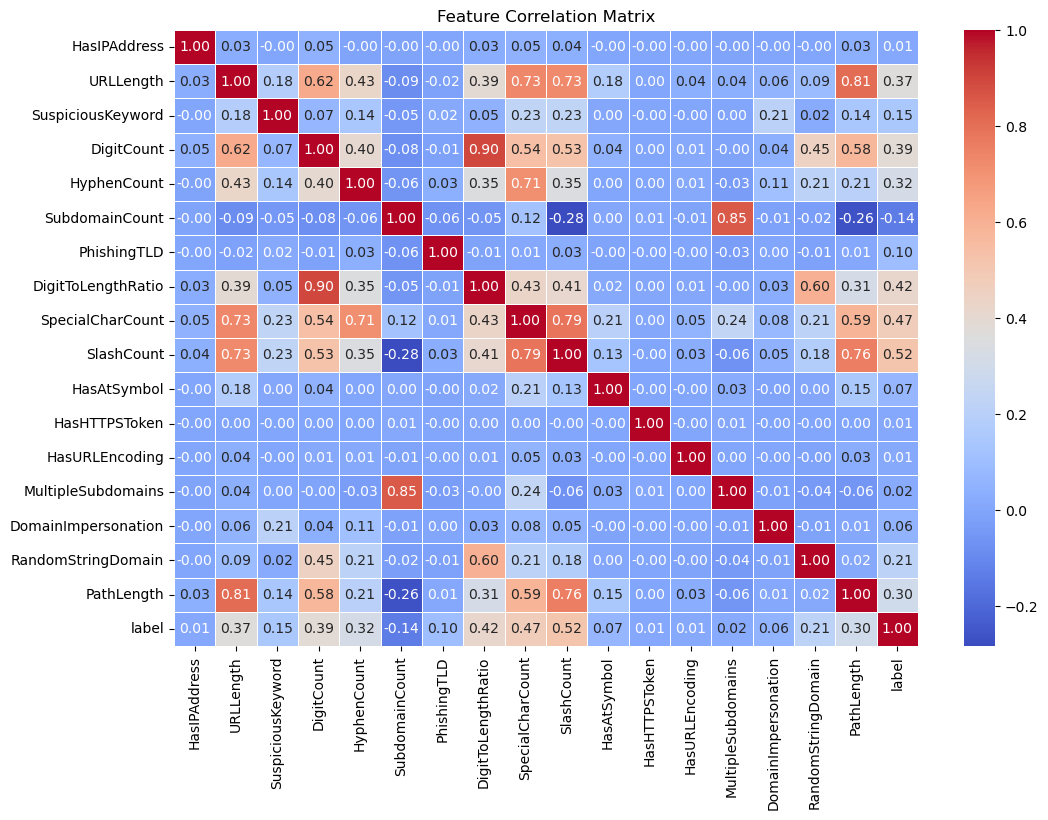

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df_fs.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [21]:
X = df_fs.drop(columns=['label'])
y = df_fs['label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [22]:
from collections import Counter

# Check class distribution
class_counts = Counter(y_train)
print(f"Class Distribution (Training Set): {class_counts}")


Class Distribution (Training Set): Counter({0: 72957, 1: 50426})


In [138]:
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to balance the classes
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# # Check new class distribution
# balanced_counts = Counter(y_train_balanced)
# print(f"Balanced Class Distribution: {balanced_counts}")


In [23]:
df_fs.to_csv("dataset/cleaned_preprocessed_dataset.csv", index=False)

Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , f1_score
from sklearn.model_selection import cross_val_score

modelrf = RandomForestClassifier(n_estimators=100, random_state=42)
modelrf.fit(X_train, y_train)

y_pred = modelrf.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(modelrf, X, y, cv=10, scoring='accuracy')
cv_mean_accuracy = np.mean(cv_scores)

accuracy, f1, cv_mean_accuracy




(0.8496567635545301, 0.780350334309554, 0.8494971452605405)

SVM ( Took more than an hour to Train , Impracticle )

In [142]:
# from sklearn.svm import SVC

# svm_model = SVC(kernel='rbf', probability=True, random_state=42)
# svm_model.fit(X_train, y_train)

# y_pred_svm = svm_model.predict(X_test)

# f1_svm = f1_score(y_test, y_pred_svm)
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# cv_scores_svm = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')
# cv_mean_accuracy_svm = np.mean(cv_scores_svm)

# accuracy_svm, f1_svm, cv_mean_accuracy_svm

In [143]:
#!pip install xgboost

XGBoost

In [25]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier( eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=10, scoring='accuracy')
cv_mean_accuracy_xgb = np.mean(cv_scores_xgb)

accuracy_xgb, f1_xgb, cv_mean_accuracy_xgb

(0.8502619187200968, 0.7811981872443904, 0.849661674610755)

Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(random_state=42, max_iter=500)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

f1_log_reg = f1_score(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
cv_scores_log_reg = cross_val_score(log_reg_model, X_test, y_test, cv=10, scoring='accuracy')
cv_mean_accuracy_log_reg = np.mean(cv_scores_log_reg)

f1_log_reg , accuracy_log_reg , cv_mean_accuracy_log_reg



(0.7675521821631879, 0.842470545963426, 0.8425083168631877)

In [146]:
#!pip install tensorflow

Neural Netowrk

In [27]:
import tensorflow as tf
from tensorflow import keras

nn_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Neural Network
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test set
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)

# Compute evaluation metrics
f1_nn = f1_score(y_test, y_pred_nn)
accuracy_nn = accuracy_score(y_test, y_pred_nn)

f1_nn, accuracy_nn

C:\Users\anshm\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8386 - loss: 0.3926 - val_accuracy: 0.8489 - val_loss: 0.3729
Epoch 2/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8487 - loss: 0.3698 - val_accuracy: 0.8480 - val_loss: 0.3702
Epoch 3/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8470 - loss: 0.3716 - val_accuracy: 0.8496 - val_loss: 0.3692
Epoch 4/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8497 - loss: 0.3678 - val_accuracy: 0.8496 - val_loss: 0.3680
Epoch 5/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8472 - loss: 0.3716 - val_accuracy: 0.8488 - val_loss: 0.3675
Epoch 6/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8465 - loss: 0.3735 - val_accuracy: 0.8493 - val_loss: 0.3675
Epoch 7/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8493 - loss: 0.3675 - val_accuracy: 0.8497 - val_loss: 0.3679
Epoch 8/10
3856/3856 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8491 - loss: 0

(0.7802633402633402, 0.8500917188297812)

ROC Curve for all Trained Models

1653/1653 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


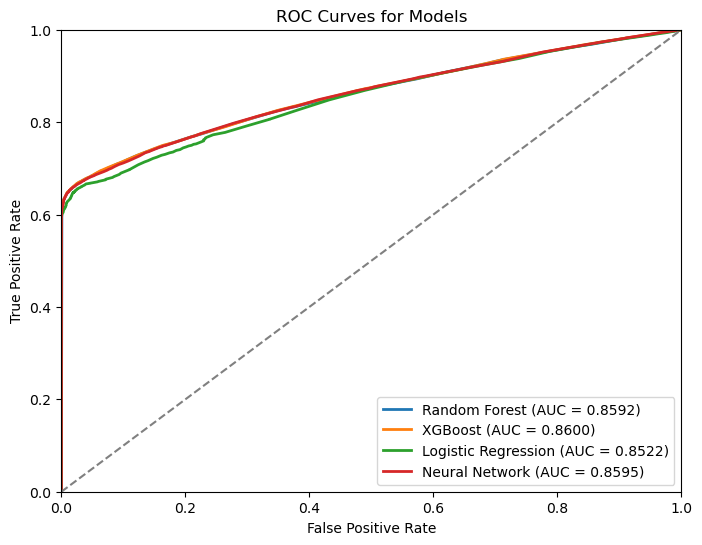

In [30]:
plt.figure(figsize=(8, 6))

model_roc_data = {
    "Random Forest": modelrf.predict_proba(X_test)[:, 1],
    "XGBoost": xgb_model.predict_proba(X_test)[:, 1],
    "Logistic Regression": log_reg_model.predict_proba(X_test)[:, 1],
    "Neural Network": nn_model.predict(X_test).flatten(),
}

for model_name, y_prob in model_roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])  # Changed scale to normal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend(loc="lower right")

# Show plot
plt.show()


Confusion Matrix for all Trained Models

1653/1653 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


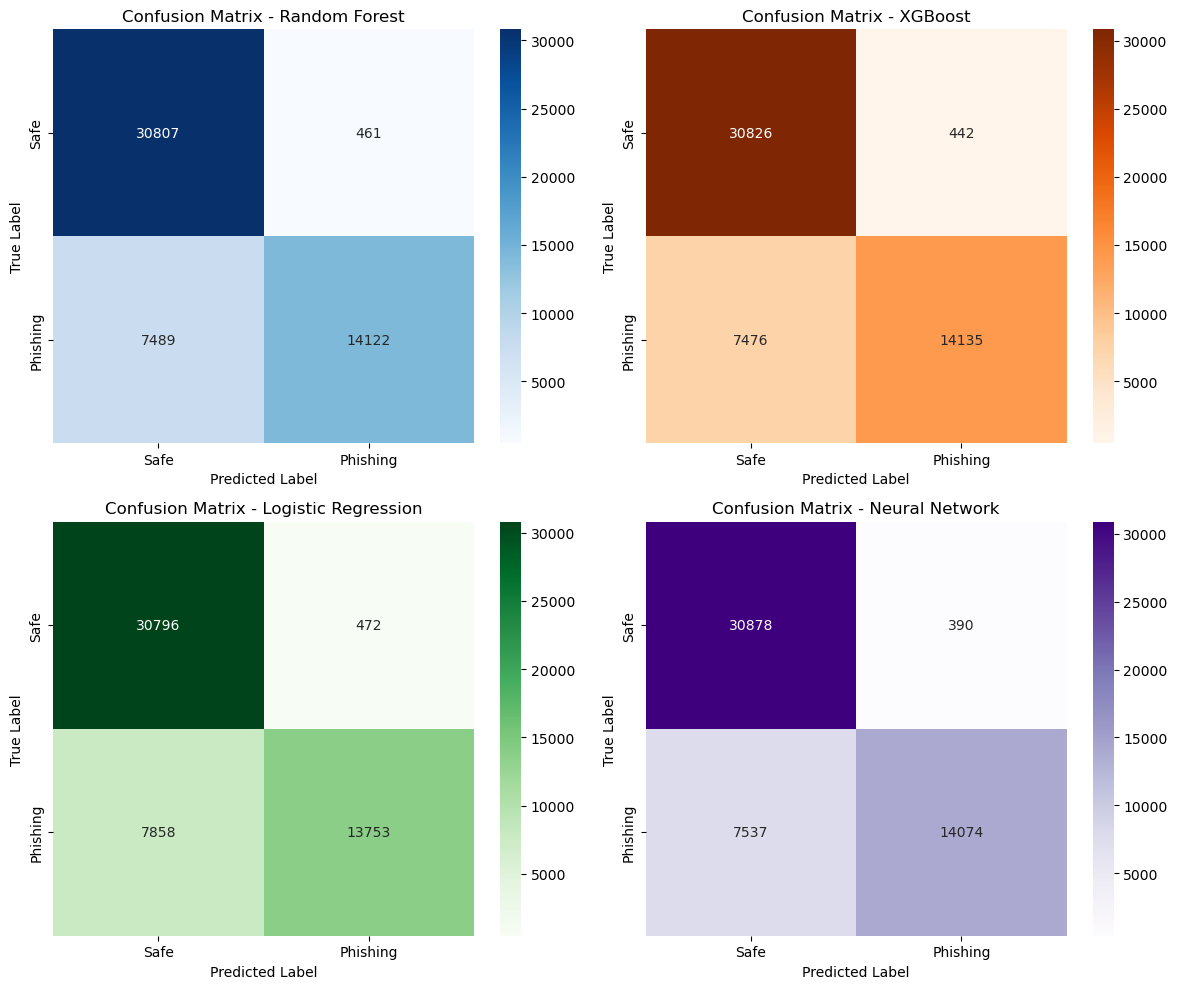

In [29]:
plt.figure(figsize=(12, 10))

model_conf_matrix_data = {
    "Random Forest": (modelrf.predict(X_test), "Blues"),
    "XGBoost": (xgb_model.predict(X_test), "Oranges"),
    "Logistic Regression": (log_reg_model.predict(X_test), "Greens"),
    "Neural Network": ((nn_model.predict(X_test).flatten() > 0.5).astype(int), "Purples")
}

for i, (model_name, (y_pred, cmap)) in enumerate(model_conf_matrix_data.items(), 1):
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")

plt.tight_layout()
plt.show()


In [31]:
joblib.dump(xgb_model, "phishing_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model Saved Successfully!")

Model Saved Successfully!
